<a href="https://colab.research.google.com/drive/1Vy3sWDDZI_jZKd4n-xorTKHmSEhr4O75?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [95]:
!pip install optuna
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import optuna
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [96]:
# Loading the dataset

train_dataset = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/Project/main/train.csv')
test_dataset = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/Project/main/test.csv')

# Selecting features - Train Set

train_dataset = train_dataset[["MSSubClass", "OverallQual", "YearBuilt", "YearRemodAdd", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "HalfBath", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "MoSold", "YrSold", "SalePrice"]]

# X and y - Train Set

X_train = pd.get_dummies(train_dataset.drop('SalePrice', axis=1))
y_train = train_dataset['SalePrice']

# Selecting features - Test Set

test_dataset = test_dataset[["MSSubClass", "OverallQual", "YearBuilt", "YearRemodAdd", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "HalfBath", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "MoSold", "YrSold"]]
X_test = pd.get_dummies(test_dataset)

In [97]:
def score_dataset(X, y, model=XGBRegressor(**xgb_params)):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Use RMSLE (Root Mean Squared Log Error) instead of MSE (Mean Squared Error)as evaluation metric
    # (So, we need to log-transform y to train and exp-transform the predictions)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring='neg_mean_squared_error'
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [98]:
# Hyperparameter Tuning

xgb_params = dict(
    max_depth=4,                            # Maximum depth of each tree - try 2 to 10
    learning_rate=0.0058603076512435655,    # Effect of each tree - try 0.0001 to 0.1
    n_estimators=5045,                      # Number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=2,                     # Minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.22556099175248345,   # Fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.5632348136091383,           # Fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.09888625622197889,          # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.00890758697724437,         # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,                    # Set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.1434139569570162

In [99]:
def objective(trial):
     xgb_params = dict(
         max_depth=trial.suggest_int("max_depth", 2, 10),
         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
         subsample=trial.suggest_float("subsample", 0.2, 1.0),
         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
     )
     xgb = XGBRegressor(**xgb_params)
     return score_dataset(X_train, y_train, xgb)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
xgb_params = study.best_params
xgb_params

[I 2023-07-11 21:25:30,447] A new study created in memory with name: no-name-7b13ac1b-d026-40c7-96ad-0c12eceae2f5
[I 2023-07-11 21:26:31,742] Trial 0 finished with value: 0.15733219237630097 and parameters: {'max_depth': 8, 'learning_rate': 0.0813733965263368, 'n_estimators': 5151, 'min_child_weight': 8, 'colsample_bytree': 0.9643203170134345, 'subsample': 0.7444513474381127, 'reg_alpha': 0.21288068517187, 'reg_lambda': 0.00940743947953277}. Best is trial 0 with value: 0.15733219237630097.
[I 2023-07-11 21:26:42,705] Trial 1 finished with value: 0.4975777493464084 and parameters: {'max_depth': 3, 'learning_rate': 0.0007813474817110755, 'n_estimators': 4415, 'min_child_weight': 7, 'colsample_bytree': 0.2941185656168996, 'subsample': 0.9555757432181164, 'reg_alpha': 26.2009957402245, 'reg_lambda': 0.00023139546726252014}. Best is trial 0 with value: 0.15733219237630097.
[I 2023-07-11 21:28:09,126] Trial 2 finished with value: 0.15256119526583328 and parameters: {'max_depth': 10, 'learnin

{'max_depth': 8,
 'learning_rate': 0.0037507718487609486,
 'n_estimators': 7677,
 'min_child_weight': 3,
 'colsample_bytree': 0.2893164296072384,
 'subsample': 0.8789872928346718,
 'reg_alpha': 0.00047399203387687533,
 'reg_lambda': 0.0010740434330192184}

In [100]:
# Train Model and Create Predictions

xgb = XGBRegressor(**xgb_params)

# XGB minimizes MSE, but we want to minimize RMSLE
# So, we need to log-transform y to train and exp-transform the predictions

xgb.fit(X_train, np.log(y_train))
predictions = np.exp(xgb.predict(X_test))
predictions

array([126098.16, 148638.17, 187346.23, ..., 152697.55, 110355.95,
       243650.25], dtype=float32)

In [101]:
# SHAP Values to explain individual predictions

data_for_prediction = {'MSSubClass': [83], 'OverallQual': [4], 'YearBuilt': [1917], 'YearRemodAdd': [1984], 'BsmtUnfSF': [792], 'TotalBsmtSF': [2768], '1stFlrSF': [1913], '2ndFlrSF': [721], 'GrLivArea': [2525], 'FullBath': [1], 'HalfBath': [1], 'TotRmsAbvGrd': [6], 'Fireplaces': [1], 'GarageCars': [2], 'GarageArea': [495], 'MoSold': [5], 'YrSold': [2007]}
data_for_prediction = pd.DataFrame(data_for_prediction)
data_for_prediction = pd.get_dummies(data_for_prediction)
predictions = np.exp(xgb.predict(data_for_prediction))
predictions

# Generate prediction
y_sample = np.exp(xgb.predict(data_for_prediction))

# Create object that can calculate Shap values
explainer = shap.TreeExplainer(xgb)

# Calculate Shap values from prediction
shap_values = explainer.shap_values(data_for_prediction)

In [102]:
float(np.asarray(predictions))

211909.796875

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


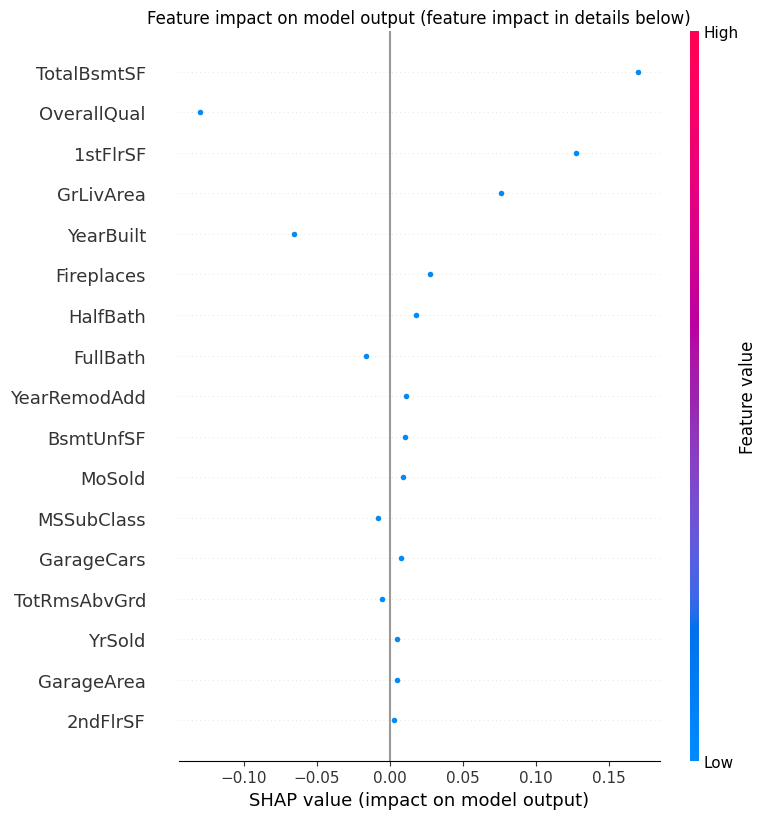

In [103]:
# Feature effect on particular prediction

plt.title('Feature impact on model output (feature impact in details below)')
shap.summary_plot(shap_values, data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [ ]:
# Aggregated effect

# Use test set to get predictions
data_for_prediction = X_test

# Generate predictions
y_sample = np.exp(xgb.predict(data_for_prediction))

# Create object that can calculate Shap values
explainer = shap.TreeExplainer(xgb)

# Calculate Shap values from predictions
shap_values = explainer.shap_values(data_for_prediction)

In [ ]:
# Feature impact on overall

plt.title('Feature impact on overall model output (feature impact in details below)')
shap.summary_plot(shap_values, data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)